In [1]:
import random
from os import path

import numpy as np
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import dataloaders
import networks.sndcgan as sndcgan
import networks.utils as utils

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data", "tmdb-64")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3  # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
PADDING_MODE = "reflect"
COLORMODE = "RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs", "sndcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 1
SAVE_FAKES_EVERY_N_EPOCHS = 1

MODEL_TO_LOAD = path.join(OUT_PATH, "2022-09-25_17-52-56/gan_at_epoch_0001.pt")
#MODEL_TO_LOAD = None

### Load dataset

In [5]:
# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREADS,
                                           pin_memory=True)

Sample dataset:

The dataset has 224094 entries.


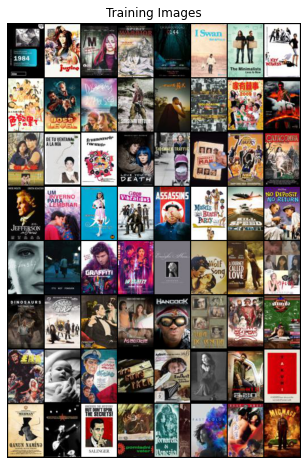

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [7]:
generator, discriminator = sndcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                              num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                              base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G,
                                              base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D,
                                              padding_mode=PADDING_MODE, device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, 1, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, 96, 64))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14        

In [8]:
from contextlib import redirect_stdout

with open(path.join(OUT_PATH, "architectures.txt"), "w") as file:
    with redirect_stdout(file):
        print("Generator:")
        summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, IMAGE_SIZE_RATIO, 1))
        print("\nDiscriminator:")
        summary(discriminator, input_size=(3, IMAGE_SIZE * IMAGE_SIZE_RATIO // 2, IMAGE_SIZE))

In [9]:
trainer = sndcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE,
                                 num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO,
                                 d_params=discriminator.parameters(), g_params=generator.parameters(),
                                 learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

[1/5]	Loss_D: 1.3720	Loss_G: 0.7150	D(x): 0.5043	D(G(z)): 0.4946 / 0.4901: 100%|██████████| 3502/3502 [18:12<00:00,  3.20it/s]


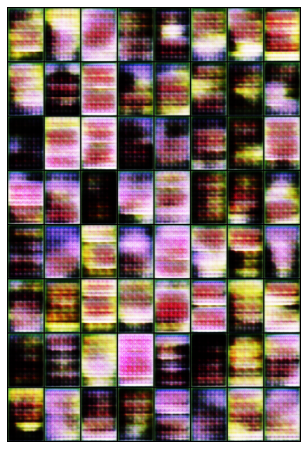

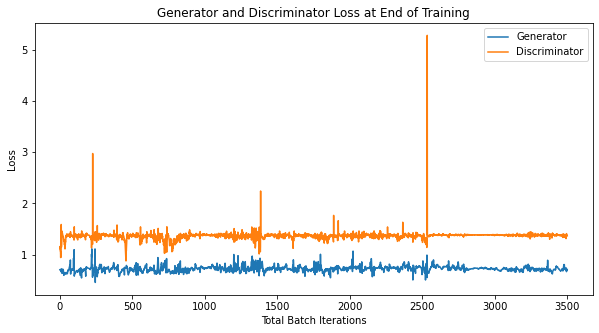

[2/5]	Loss_D: 1.2208	Loss_G: 0.8777	D(x): 0.5767	D(G(z)): 0.4268 / 0.4257: 100%|██████████| 3502/3502 [17:59<00:00,  3.24it/s]


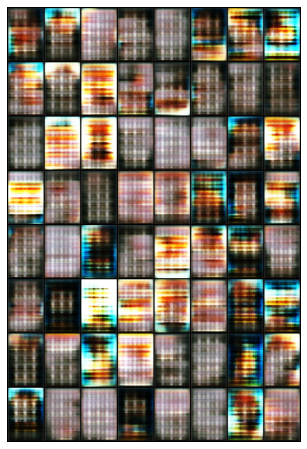

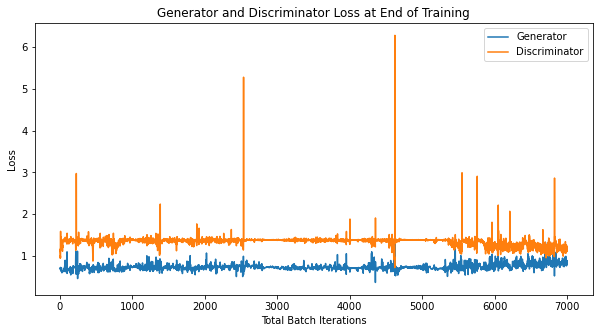

[3/5]	Loss_D: 0.6029	Loss_G: 1.2401	D(x): 0.8744	D(G(z)): 0.2818 / 0.3075: 100%|██████████| 3502/3502 [17:54<00:00,  3.26it/s]


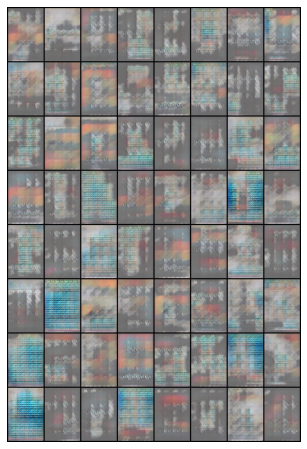

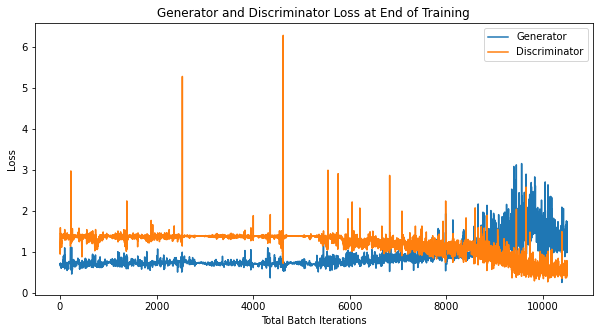

[4/5]	Loss_D: 0.4023	Loss_G: 1.2121	D(x): 0.8485	D(G(z)): 0.1415 / 0.3122: 100%|██████████| 3502/3502 [17:45<00:00,  3.29it/s]


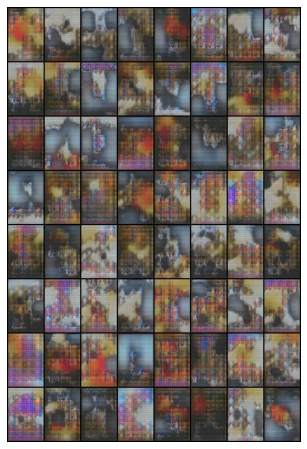

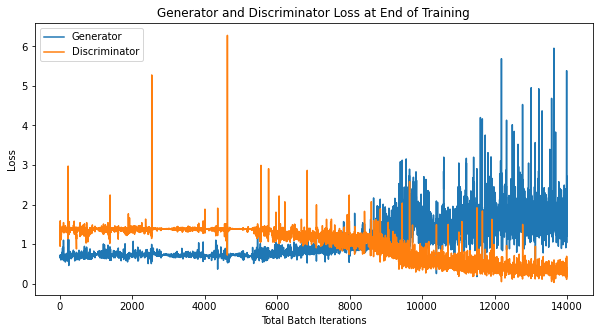

[5/5]	Loss_D: 0.1773	Loss_G: 2.3731	D(x): 0.9797	D(G(z)): 0.1430 / 0.0971: 100%|██████████| 3502/3502 [17:43<00:00,  3.29it/s]


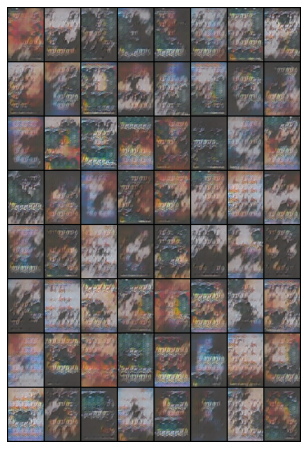

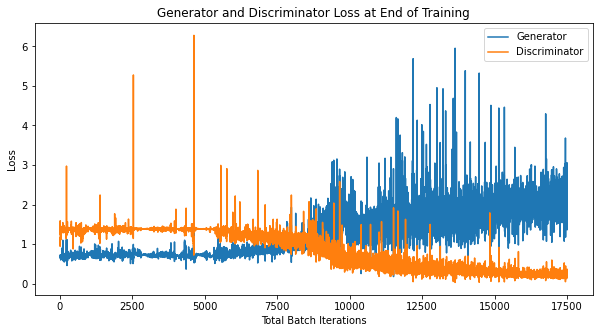

In [10]:
SHOW_GRAPHS = True

trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device,
              fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS,
              model_to_load=MODEL_TO_LOAD, show_graphs=SHOW_GRAPHS)

### Show results

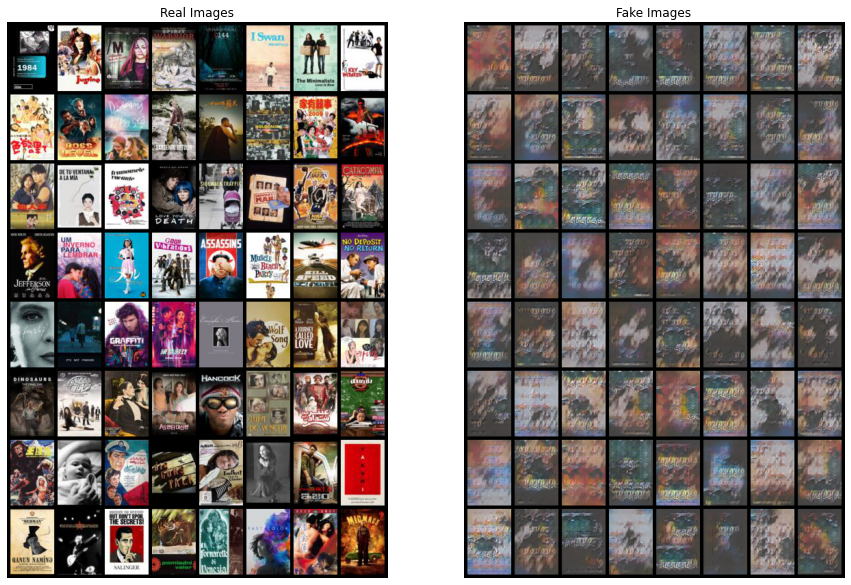

In [11]:
utils.plot_reals_vs_fakes(generator, trainer, sample_reals, NUM_SAMPLES,
                          path.join(trainer.last_out_dir, "real_vs_fake.png"), device)